# Sparkify - Udacity DSND Capstone Project
## Table of contents
1. [Project Definition](#definition)
2. [Importing packages and setup](#packages)
3. [Load and Clean Dataset](#loadclean)
  1. [Loading data](#loading)
  2. [Exploring data](#exploring)
  3. [Cleaning data](#cleaning)    
4. [Exploratory Data Analysis](#exploratory)
  1. [Define Churn Events](#definechurn)
      1. [Churn as a "Confirm Cancellation" event](#confirmcancel)
      2. [Churn as a "Submit Downgrade" event](#downgrade)
  2. [Explore Data](#explore)
5. [Feature Engineering](#featureeng)
  1. [Creating new User Features](#newfeatures)
  2. [Putting All Together](#alltogether)
6. [Modeling](#modeling)
  1. [Vectorize, Scaling and Split data](#vectandsplit)
  2. [Train, Predict and Tune](#trainpredict)
  3. [Model Selection and Results](#selection)
7. [Conclusions](#conclusions)
---

# 1. Project Definition <a id='definition'></a>


#### Introduction

Sparkify is a music streaming service (similar to Apple Music and Spotify) where customers can hear their favourite musics. This service can be used for free, but some customers prefer to have a premium (paid) account, which allows to eliminate advertising between songs and other benefits.

The collected data corresponds to the log of events, measuring every interaction and activity that users perform in the application. Every event is a row in the dataset and collects the following information:

`root
 |-- artist: string
 |-- auth: string 
 |-- firstName: string 
 |-- gender: string 
 |-- itemInSession: long 
 |-- lastName: string 
 |-- length: double
 |-- level: string 
 |-- location: string 
 |-- method: string 
 |-- page: string 
 |-- registration: long 
 |-- sessionId: long
 |-- song: string 
 |-- status: long 
 |-- ts: long 
 |-- userAgent: string
 |-- userId: string`
 
As an online service, the amount of data collected every minute is huge. For this reason, and due to the limitation of computational capacity to work with larger datasets, in this project we will only use a medium sample, with about 4GB. The pyspark package will be used in every steps: loading, cleaning, transformating and modeling data

#### Problem Definition

The purpose of this project is to predict the customer's churn based on their behavior and previous activities. For that purpose it will be needed to understand data and then generate new meaningfull features that characterize user experience in Sparkify, so that we can use a machine learning model to predict which customers are likely to churn.


# 2. Importing packages and setup <a id='packages'></a>

Importing libraries and setting up spark session

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import datetime
%matplotlib inline

# pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf, col, countDistinct, sum, avg, when, desc, asc, isnan, count, sort_array 
from pyspark.sql.functions import split, rank, concat,lit, stddev, max, min
from pyspark.sql.types import StringType, IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.feature import Normalizer, StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, GBTClassifier, LinearSVC, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200620125239-0000
KERNEL_ID = 3614d1f6-c313-41ea-9018-01e04ed51c2c


In [2]:
# create a Spark session
spark = SparkSession\
        .builder\
        .appName("Sparkify")\
        .getOrCreate()

#spark.conf.set("spark.sql.shuffle.partitions", 4)

# 3. Load and Clean Dataset <a id='loadclean'></a>
In this workspace, the medium-dataset file was used. In this section we will load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## 3.1 Loading data <a id='loading'></a>

In [3]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-a1a0d823-2267-4c3e-bd84-5969266fd61a',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'DddCx_hXmcU6NPCbZ1NGp5p4UJG0JX1L36rmZ0GVSVRZ'
}

configuration_name = 'os_079c5c628e9a40fb9e7bc3c19ebfb909_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-hcuyrew6c31cer'))
df.take(5)


[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

## 3.2 Exploring data <a id='exploring'></a>

In [4]:
df.head()

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293')

In [5]:
# Show top two rows of df dataframe
df.show(n=2,vertical = True)

-RECORD 0-----------------------------
 artist        | Martin Orford        
 auth          | Logged In            
 firstName     | Joseph               
 gender        | M                    
 itemInSession | 20                   
 lastName      | Morales              
 length        | 597.55057            
 level         | free                 
 location      | Corpus Christi, TX   
 method        | PUT                  
 page          | NextSong             
 registration  | 1532063507000        
 sessionId     | 292                  
 song          | Grand Designs        
 status        | 200                  
 ts            | 1538352011000        
 userAgent     | "Mozilla/5.0 (Mac... 
 userId        | 293                  
-RECORD 1-----------------------------
 artist        | John Brown's Body    
 auth          | Logged In            
 firstName     | Sawyer               
 gender        | M                    
 itemInSession | 74                   
 lastName      | Larson  

In [6]:
# Print schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# Total number of rows
df.count()

543705

In [8]:
# Total number of columns
len(df.columns)

18

In [9]:
# Print total number of distinct artists
print('Number of distinct artists:', df.select("artist").distinct().count())

# Show distinct "artists"
df.select("artist").distinct().show()

Number of distinct artists: 21248
+--------------------+
|              artist|
+--------------------+
|      The Black Keys|
|        Yann Tiersen|
|    Jane's Addiction|
|          Tim Hughes|
|Dashboard Confess...|
|                Silk|
|Yonder Mountain S...|
|            La Shica|
|        Elvis Crespo|
|         Silverstein|
|         Eva Cassidy|
|        Generation X|
|     Robyn Hitchcock|
|           Kate Nash|
|       Jupiter Jones|
|           Los Lobos|
|               Rufio|
|     Drive Like Jehu|
|       Yuichi Tamate|
|      Jarabe De Palo|
+--------------------+
only showing top 20 rows



In [10]:
# Print total number of distinct songs
print('Number of distinct songs:', df.select("song").distinct().count())

# Show distinct "songs"
df.select("song").distinct().show()

Number of distinct songs: 80293
+--------------------+
|                song|
+--------------------+
|             Sitting|
|              Heaven|
|Turn Your Lights ...|
|Never Gonna Be Al...|
|  Setting vs. Rising|
|What's A Broken H...|
|          Nightmares|
|       One Sweet Day|
|            El Colmo|
|   Two Ocean Plateau|
|              Remedy|
|            Kiss Off|
|    Mood For Trouble|
|         Anywhere Is|
|           Explosive|
|         TULENLIEKKI|
|Forgotten (Lost A...|
|          Sea-Shells|
|      Billy Breathes|
|         AquaCityBoy|
+--------------------+
only showing top 20 rows



In [11]:
# Show top 20 most played songs
df.select(['ts','song']).groupby('song').count().sort('count', ascending = False).show()

+--------------------+------+
|                song| count|
+--------------------+------+
|                null|110828|
|      You're The One|  2219|
|                Undo|  1938|
|             Revelry|  1613|
|       Sehr kosmisch|  1341|
|Horn Concerto No....|  1236|
|Dog Days Are Over...|  1048|
|             Secrets|   916|
|        Use Somebody|   894|
|              Canada|   836|
|             Invalid|   801|
|    Ain't Misbehavin|   767|
|       ReprÃÂ©sente|   766|
|              Yellow|   744|
|Catch You Baby (S...|   718|
|SinceritÃÂ© Et J...|   688|
|    Somebody To Love|   686|
|            The Gift|   612|
|            Tive Sim|   586|
|           Fireflies|   586|
+--------------------+------+
only showing top 20 rows



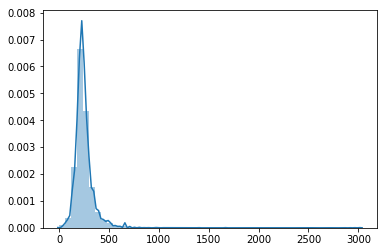

In [12]:
#Plot song 'length' distribution in seconds
sns.distplot(df.select('length').toPandas().dropna());

In [13]:
# Print total number of distinct pages
print('Number of distinct pages:', df.select("page").distinct().count())

# Count number of user per distinct "pages" - Most seen pages by users
df.select(["userId","page"]).groupby("page").count().sort("count", ascending = False).show()

Number of distinct pages: 22
+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|432877|
|                Home| 27412|
|           Thumbs Up| 23826|
|     Add to Playlist| 12349|
|          Add Friend|  8087|
|         Roll Advert|  7773|
|               Login|  6011|
|              Logout|  5990|
|         Thumbs Down|  4911|
|           Downgrade|  3811|
|                Help|  3150|
|            Settings|  2964|
|               About|  1855|
|             Upgrade|   968|
|       Save Settings|   585|
|               Error|   519|
|      Submit Upgrade|   287|
|    Submit Downgrade|   117|
|Cancellation Conf...|    99|
|              Cancel|    99|
+--------------------+------+
only showing top 20 rows



> As we can see in the table above, the "NextSong" page has 18 times more pageviews than the homepage itself (second in the table), marking with a large margin the users most frequent activity. Next we will see the remaining activities, removing the influence of the "NextSong" page.

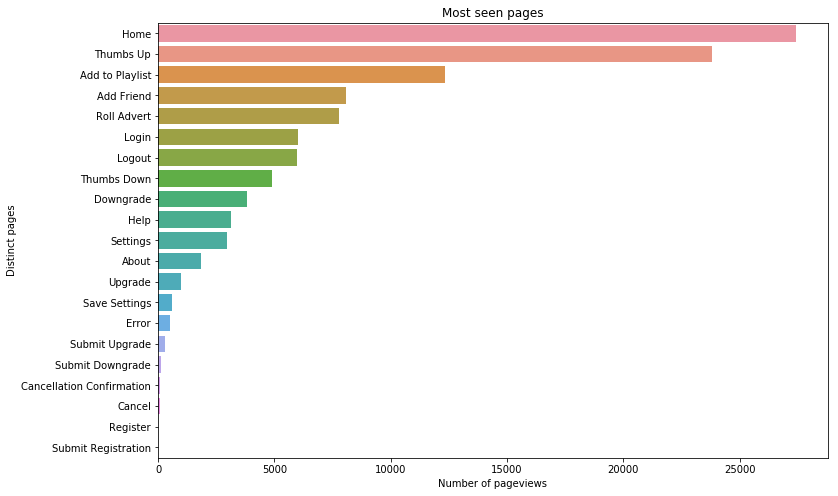

In [14]:
# Plot the most seen pages
most_seen_pages = df.select(["userId","page"]).groupby("page").count().sort("count", ascending = False).toPandas()

plt.figure(figsize=(12, 8))
ax = sns.barplot(x="count", y="page", data= most_seen_pages[most_seen_pages.page != 'NextSong'])
ax.set_title("Most seen pages")
ax.set_xlabel("Number of pageviews")
ax.set_ylabel("Distinct pages");

In [15]:
# Show distinct authentication status
df.select('auth').distinct().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



In [16]:
# Count number of user per each authentication status
df.select('userId','auth').dropDuplicates().groupby('auth').count().show()

+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out|    1|
| Cancelled|   99|
|     Guest|    1|
| Logged In|  448|
+----------+-----+



> When users are *Logged Out* or are *Guests* do not have a `userId` defined

In [17]:
# Count number of user per distinct "levels"
df.select(["userId","level"]).dropDuplicates().groupby("level").count().show()

# although a user can start with a free account and upgrade to a paid account later

+-----+-----+
|level|count|
+-----+-----+
| free|  371|
| paid|  322|
+-----+-----+



In [18]:
# Show distinct "methods"
df.select('method').distinct().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [19]:
# Show distinct "status"
df.select(["userId","status"]).dropDuplicates().groupby("status").count().show()

+------+-----+
|status|count|
+------+-----+
|   307|  447|
|   404|  224|
|   200|  449|
+------+-----+



In [20]:
# Show total number of distinct users
df.select('userId').distinct().count()

449

In [21]:
# Show total number of distinct sessions
df.select('sessionId').distinct().count()

4590

In [22]:
# Count number of user by gender
df.select(["userId","gender"]).dropDuplicates().groupby("gender").count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|  198|
|  null|    1|
|     M|  250|
+------+-----+



In [23]:
# Create 'state' column from spliting using 'location' information
df = df.withColumn('state', split(col('location'),',').getItem(1))

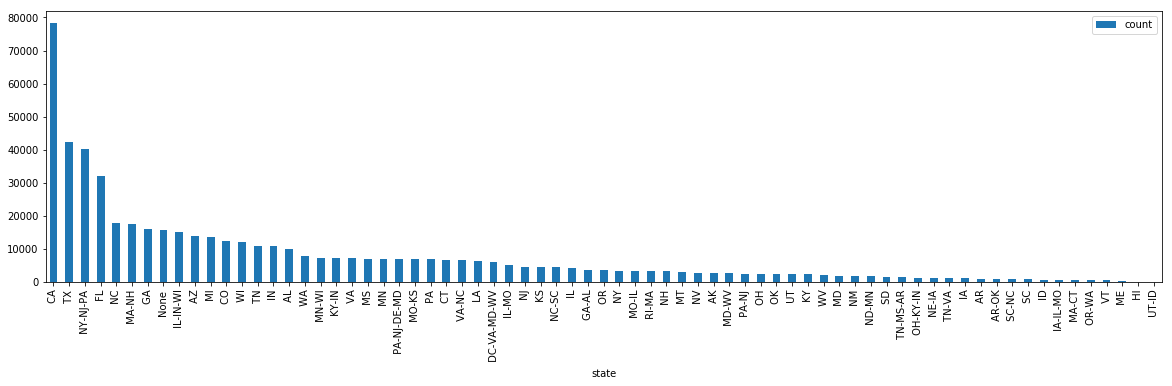

In [24]:
# Calculate the number of users in each state
users_per_state = df.select(['userId','state']).groupby('state').count().sort('count',ascending=False).toPandas()
users_per_state.plot(x = 'state', kind='bar',figsize=(20,5));

In [25]:
# Check for missing values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical = True)

-RECORD 0---------------
 artist        | 110828 
 auth          | 0      
 firstName     | 15700  
 gender        | 15700  
 itemInSession | 0      
 lastName      | 15700  
 length        | 110828 
 level         | 0      
 location      | 15700  
 method        | 0      
 page          | 0      
 registration  | 15700  
 sessionId     | 0      
 song          | 110828 
 status        | 0      
 ts            | 0      
 userAgent     | 15700  
 userId        | 0      
 state         | 15700  



> As we can see, all the attributes that concern the session variables (like *ts, status, sessionId, userId, itemInSession, page*) are complete. So apparently there is no invalid record.

> However, there seems to be a pattern in the missing values for the remaining variables.
* `artist`, `length` and `song` have 110 828 missing values;
* `firstName`, `gender`, `lastName`, `location`, `registration` and `userAgent` have 15 700 missing values.

> Records with missing `artist`, `song` and `length` are records that are not related to music events. For instance, it occurs when the `page` is "Thumbs Up", "Thumbs Down", "Home", "Logout", "Roll Advert", "Add to Playlist", "Upgrade", and others. It is not an error and should not be removed or filled with some value. 


In [28]:
#Check for empty values
df.select([count(when(col(c)=='', c)).alias(c) for c in df.columns]).show(vertical = True)

-RECORD 0--------------
 artist        | 0     
 auth          | 0     
 firstName     | 0     
 gender        | 0     
 itemInSession | 0     
 lastName      | 0     
 length        | 0     
 level         | 0     
 location      | 0     
 method        | 0     
 page          | 0     
 registration  | 0     
 sessionId     | 0     
 song          | 0     
 status        | 0     
 ts            | 0     
 userAgent     | 0     
 userId        | 15700 
 state         | 0     



> The **15 700** events in which `firstName`, `gender`, `lastName`, `location`, `registration` and `userAgent` are null values correspond to scenarios in which:
* users did not give permissions to capture data, for instance, by refusing browser cookies
* the user is not identified, browsing the site without logging in.

> For these same scenarios a `userId` is not generated, appearing as empty as we can see with the image above. These records will be dropped in the steps. 

## 3.3 Cleaning data <a id='cleaning'></a>

In [29]:
# Drop rows with unregistered users
df = df.filter(df.userId != "")

In [30]:
# Check again for missing values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical = True)

-RECORD 0--------------
 artist        | 95128 
 auth          | 0     
 firstName     | 0     
 gender        | 0     
 itemInSession | 0     
 lastName      | 0     
 length        | 95128 
 level         | 0     
 location      | 0     
 method        | 0     
 page          | 0     
 registration  | 0     
 sessionId     | 0     
 song          | 95128 
 status        | 0     
 ts            | 0     
 userAgent     | 0     
 userId        | 0     
 state         | 0     



In [31]:
# get_date Function
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).strftime("%Y-%m-%d %H:%M:%S"))

# get_hour Function
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).hour, IntegerType())

# get_day Function
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).day, IntegerType())


In [32]:
# Convert timestamps to date
df = df.withColumn("date", get_date(df.ts))
df.head()

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293', state=' TX', date='2018-10-01 00:00:11')

In [33]:
# Convert timestamps to hour
df = df.withColumn("hour", get_hour(df.ts))
df.head()

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293', state=' TX', date='2018-10-01 00:00:11', hour=0)

In [34]:
# Convert timestamps to day of the month
df = df.withColumn("day", get_day(df.ts))
df.head()

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293', state=' TX', date='2018-10-01 00:00:11', hour=0, day=1)

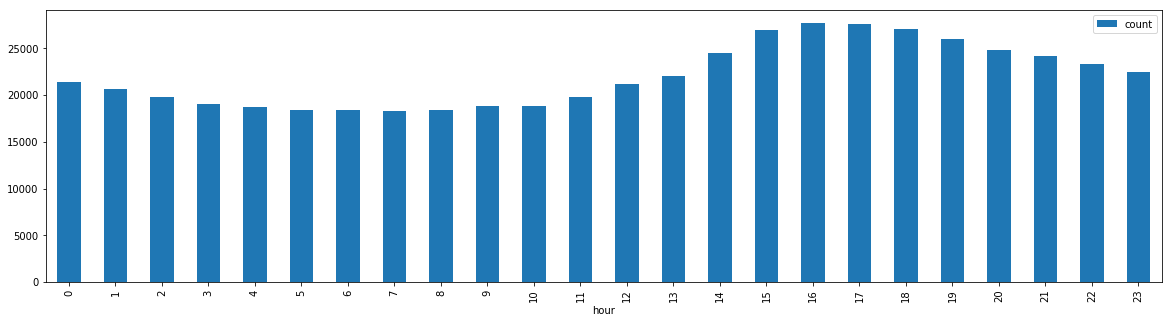

In [35]:
# Calculate the number of events per hour
events_per_hour = df.select(['userId','hour']).groupby('hour').count().sort('hour').toPandas()
events_per_hour.plot(x = 'hour', kind='bar',figsize=(20,5));

In [36]:
# Convert registration timestamp to date
df = df.withColumn("registration_date", get_date(df.registration))

# Convert registration timestamp to hour
df = df.withColumn("registration_hour", get_hour(df.registration))

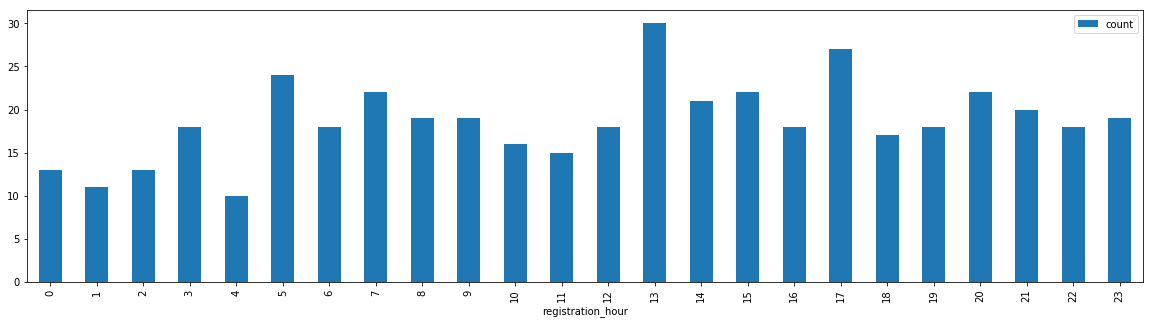

In [37]:
# Calculate the number of registations per hour
registration_per_hour = df.select(['userId','registration_hour']).dropDuplicates().groupby('registration_hour').count().sort('registration_hour').toPandas()
registration_per_hour.plot(x = 'registration_hour', kind='bar',figsize=(20,5));

# 4. Exploratory Data Analysis <a id='exploratory'></a>
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

## 4.1 Define Churn events <a id='definechurn'></a>

The concept of churn must be interpreted and defined in the context of each product and business. In the case of the Sparkify service there are several events and behaviors that can be considered churn, or even demonstrate an intention to do so. They are:

* **"Cancellation Confirmation"** page -  page viewed when canceling the account, which can happen for both paid and free users
* **"Submit Downgrade"** page - page viewed when downgrading from a paid to a  free subscription. 
* **Users without visits for more than 6 months** - the frequency of visits is a metric that can also be used to classify users' engagement with the service. However, as the dataset only refers to a couple of months, this approach cannot be tested. 

Thus, I will create a column `Churn`and another `Downgrade` to use as label for the models. 

### 4.1.1 Churn as a "Confirm Cancellaion" event <a id='confirmcancel'></a>

In [38]:
# Function to identify churn events
is_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [39]:
# Create churn column 
df = df.withColumn("churn", is_churn_event("page"))

In [40]:
# Create a partitionated window by userID
windowval = Window.partitionBy("userId")

# Sum churn flag over user window
df = df.withColumn("Fchurn", sum("churn").over(windowval))

In [41]:
df.head()

Row(artist='Darude', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=226.08934, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=62, song='Sandstorm', status=200, ts=1538991392000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', state=' CT', date='2018-10-08 09:36:32', hour=9, day=8, registration_date='2018-09-27 02:45:40', registration_hour=2, churn=0, Fchurn=1)

In [42]:
print('Number of users who have churned: {}'.\
      format(df.filter(df.Fchurn != 0).select('userId').dropDuplicates().count()))
print('Number of users who have not churned: {}'.\
      format(df.filter(df.Fchurn == 0).select('userId').dropDuplicates().count()))

Number of users who have churned: 99
Number of users who have not churned: 349


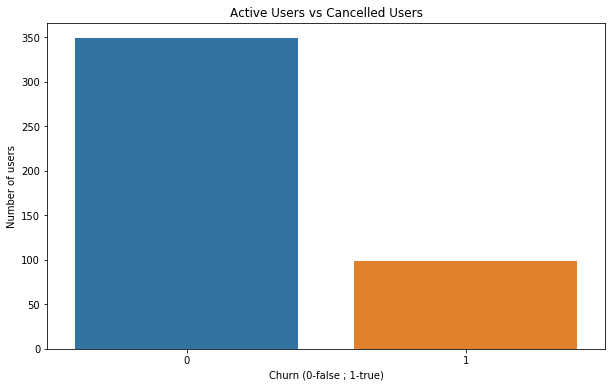

In [43]:
churn_count = df.select(['userId','Fchurn']).dropDuplicates().groupby('Fchurn').count().toPandas()

# Plot the number of active and churned users
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Fchurn", y="count", data=churn_count)
ax.set_title("Active Users vs Cancelled Users")
ax.set_xlabel("Churn (0-false ; 1-true)")
ax.set_ylabel("Number of users");

### 4.1.2 Churn as a "Submit Downgrade" event <a id='downgrade'></a>

In [44]:
# Function to identify downgrade events
is_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [45]:
# Create downgrade column 
df = df.withColumn("downgrade", is_downgrade_event("page"))

In [46]:
# Sum downgrade flag over user window
df = df.withColumn("Fdowngrade", sum("downgrade").over(windowval))

In [47]:
print('Number of users who have downgraded: {}'.\
      format(df.filter(df.Fdowngrade != 0).select('userId').dropDuplicates().count()))
print('Number of users who have not downgraded: {}'.\
      format(df.filter(df.Fdowngrade == 0).select('userId').dropDuplicates().count()))
print('Number of users with paid accounts: {}'.\
      format(df.select(['userId','level']).filter(df.level == 'paid').dropDuplicates().count()))

Number of users who have downgraded: 97
Number of users who have not downgraded: 351
Number of users with paid accounts: 321


> There was 21,7% users downgrading their services, however, when we look at the number of paid users we see that actually it represents 30% of the paid accounts.

In [48]:
# Create a partitionated window by userID ordered by descending ts
windowDesc = Window.partitionBy("userId").orderBy(col('ts').desc())

# Keep only the last record of each user
user_last_event = df.withColumn("rank", rank().over(windowDesc)).filter(col('rank') == 1).drop('rank')

In [49]:
# Check the number of user who have downgraded, and how many times
user_last_event["userId", "Fdowngrade"].dropDuplicates().groupby("Fdowngrade").count().show()

+----------+-----+
|Fdowngrade|count|
+----------+-----+
|         0|  351|
|         1|   78|
|         3|    1|
|         2|   18|
+----------+-----+



In [50]:
# Check the final level of user who have downgraded
user_last_event["userId", "Fdowngrade","level"].dropDuplicates().sort('Fdowngrade').groupby(["Fdowngrade","level"]).count().show()

+----------+-----+-----+
|Fdowngrade|level|count|
+----------+-----+-----+
|         0| free|  127|
|         0| paid|  224|
|         1| paid|   42|
|         1| free|   36|
|         2| free|    8|
|         2| paid|   10|
|         3| free|    1|
+----------+-----+-----+



> Although there are **97 users who downgraded at least once**, when comparing these numbers with the final "level" of those same users, we see that 52 ended up subscribing to the paid service again. Since the upgrade and downgrade of service is very volatile, in which users can pass through the levels several times, and there is only a sample of 45 users who after downgrading maintained their free accounts, **we will not consider this as the main event to measure Churn**

## 4.2 Explore Data <a id='explore'></a>
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Gender

In [51]:
# Check distribution by Gender
gender_count = df.select(["userId", "gender","Fchurn"]).dropDuplicates().groupby(["Fchurn", "gender"]).count().toPandas()
gender_count

,Fchurn,gender,count
0,0,F,153
1,1,M,54
2,1,F,45
3,0,M,196


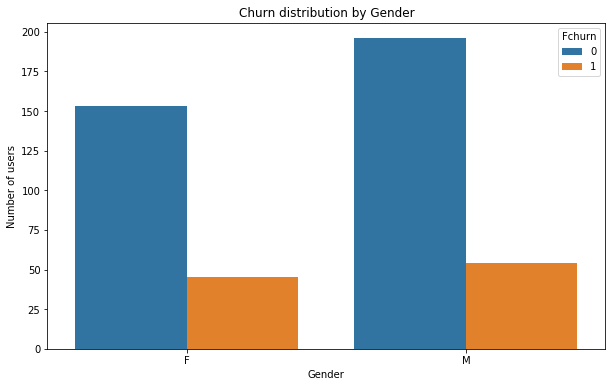

In [52]:
# Plot Churn distribution by Gender
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="gender", y="count", hue="Fchurn", data=gender_count)
ax.set_title("Churn distribution by Gender")
ax.set_xlabel("Gender")
ax.set_ylabel("Number of users");

> Obviously, the number of active customers is dominant as they represents 78% of the sample. However, as we can see the proportion of churns is very similar between both genders: **22,7% for Females and 21,6% for Males.**

### Level

In [53]:
# Check distribution by Level
level_count = df.select(["userId", "level","Fchurn"]).dropDuplicates().groupby(["Fchurn", "level"]).count().toPandas()
level_count

,Fchurn,level,count
0,1,paid,75
1,1,free,82
2,0,free,288
3,0,paid,246


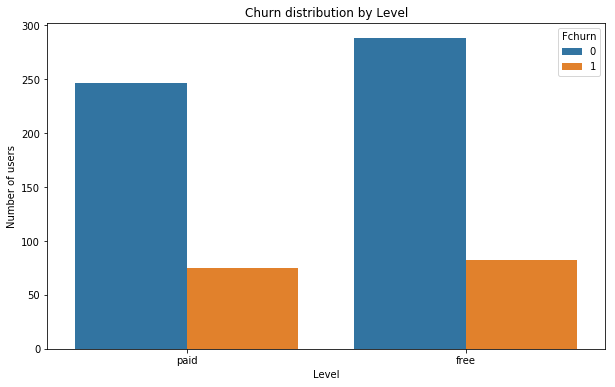

In [54]:
# Plot Churn distribution by Level
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="level", y="count", hue="Fchurn", data=level_count)
ax.set_title("Churn distribution by Level")
ax.set_xlabel("Level")
ax.set_ylabel("Number of users");

> In the case of the 2 possible levels, the number of churns is similarly distributed between the 2 groups: **23,4% churn for paid customers and 22,2% churn for free customers.**

### Location - State

In [55]:
# Check distribution by Location - state
users_per_state = df.select(["userId", "state","Fchurn"]).dropDuplicates().groupby(["Fchurn", "state"]).count().sort('count','state', ascending = False).toPandas()
users_per_state.head(25)

,Fchurn,state,count
0,0,CA,52
1,0,TX,31
2,0,NY-NJ-PA,22
3,0,FL,20
4,0,IL-IN-WI,12
5,1,CA,10
6,0,WA,8
7,1,NY-NJ-PA,8
8,0,NC,8
9,0,MI,8


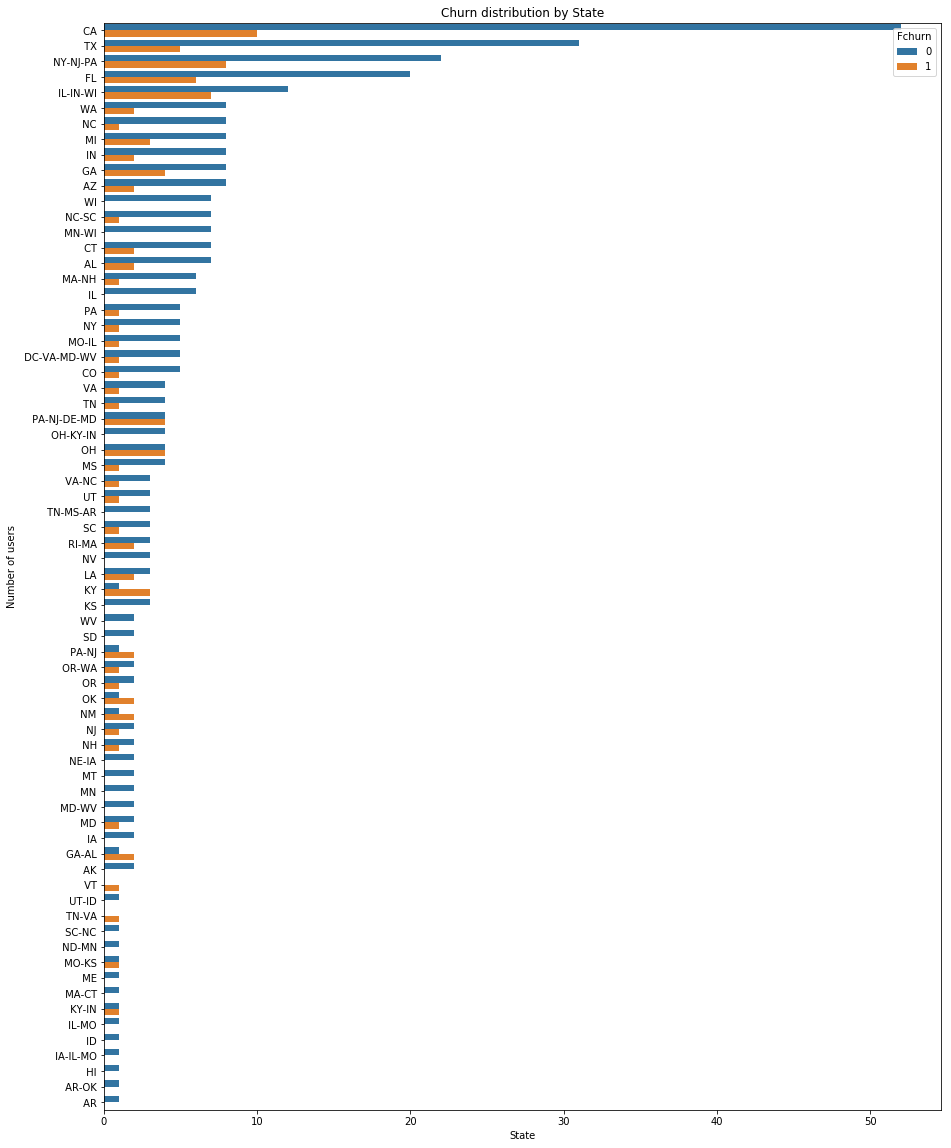

In [56]:
# Plot Churn distribution by Level
plt.figure(figsize=(15, 20))
ax = sns.barplot(x="count", y="state", hue="Fchurn", data = users_per_state)
ax.set_title("Churn distribution by State")
ax.set_xlabel("State")
ax.set_ylabel("Number of users");

> The churn rate differs between the different states. In the top 4 states with the most users, the churn percentages are:
* California (CA) - 16%
* Texas (TX) - 14%
* Florida (FL) - 23%
* New York/New Jersey (NY-NJ-PA) - 27%

> According to the bar graph most states have low Churn Rates like Illinois (IL)Connecticut,North and South Carolina, Nevada and Virginia.

> A few examples have Churn Rate equals to 50% are: Ohio, Missouri and Kansas

### Lenght

In [57]:
df.select(["Fchurn", "length"]).groupby(["Fchurn"])\
    .agg(avg("length").alias('mean_length'),
         stddev("length").alias("stddev_length"),
         max("length").alias("max_length"),
         min("length").alias("min_length")).show()

+------+------------------+-----------------+----------+----------+
|Fchurn|       mean_length|    stddev_length|max_length|min_length|
+------+------------------+-----------------+----------+----------+
|     0|248.58486352452374|98.39324443629273|3024.66567|   0.78322|
|     1|248.99398360601674|98.49278064882209|2594.87302|   4.04853|
+------+------------------+-----------------+----------+----------+



> The lenght distribution of the two types of users (active and churned) is quite similar as the average value and the standard deviation value are very close.

### Pages

In [58]:
# Check distribution by Pages
pages_count = df.select(["userId", "page","Fchurn"]).groupby(["Fchurn", "page"]).count().sort('count', ascending = False).toPandas()
pages_count

,Fchurn,page,count
0,0,NextSong,348518
1,1,NextSong,84359
2,0,Thumbs Up,19526
3,0,Home,15311
4,0,Add to Playlist,10090
5,0,Add Friend,6550
6,0,Roll Advert,5587
7,0,Logout,4806
8,1,Thumbs Up,4300
9,1,Home,3778


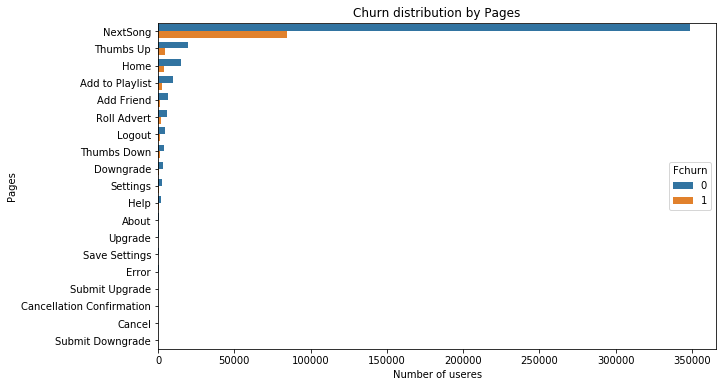

In [59]:
# Plot Churn distribution by Page
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="count", y="page", hue="Fchurn", data=pages_count)
ax.set_title("Churn distribution by Pages")
ax.set_xlabel("Number of useres")
ax.set_ylabel("Pages");

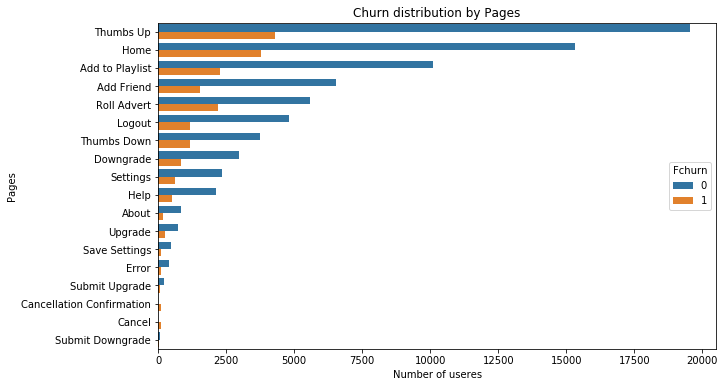

In [60]:
# Plot Churn distribution by Page, by removing the "NextSong" page 
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="count", y="page", hue="Fchurn", data=pages_count[pages_count['page']!="NextSong"])
ax.set_title("Churn distribution by Pages")
ax.set_xlabel("Number of useres")
ax.set_ylabel("Pages");

> Page Views are an indicator of the interactions and activities that users most perform on the platform. Moving on to the "NextSong" is clearly the most frequent action for both groups. Then there are the actions of "Thumbs Up" and visiting the Homepage, also for both.

> Users who cancel/churn do "Roll Advert" more often than active users.

#### Pages : Thumbs Up

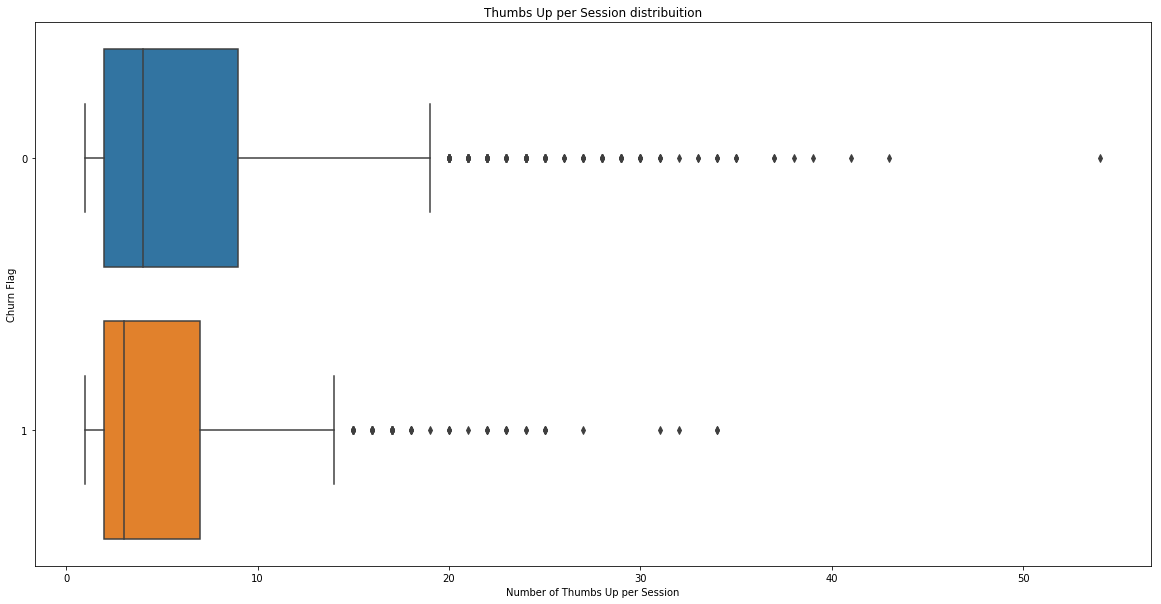

In [61]:
# Compare the number of Thumbs Up activity for active and churned users

thumbsup_count = df.filter(df['page'] == 'Thumbs Up').groupby("Fchurn", "sessionId").count().toPandas()


# Plot Thumbs Up activity per session for both segments

plt.figure(figsize=(20, 10))
ax = sns.boxplot(x='count', y='Fchurn', orient="h", data = thumbsup_count)
ax.set_title("Thumbs Up per Session distribuition")
ax.set_xlabel("Number of Thumbs Up per Session")
ax.set_ylabel("Churn Flag");

> Customers who cancel/churn tend to give less Thumbs Up per session than active customers. This can be concluded because the limit values of all quadrants are lower (mean, median and maximum value).

#### Pages : Roll Advert 

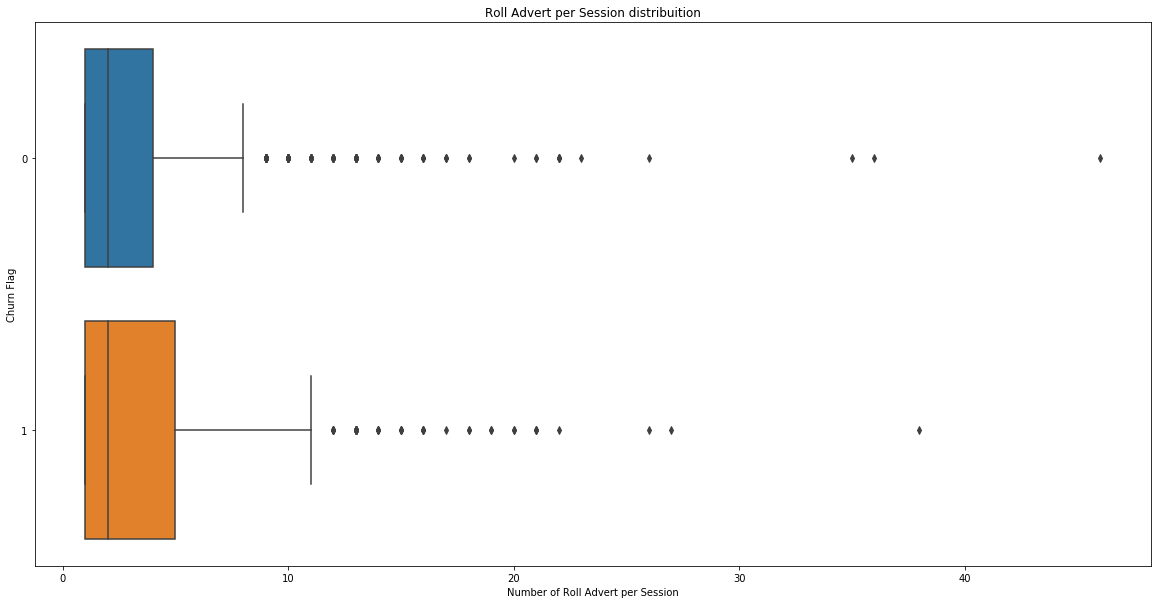

In [62]:
# Compare the number of Roll Advert activity for active and churned users

rolladvert_count = df.filter(df['page'] == 'Roll Advert').groupby("Fchurn", "sessionId").count().toPandas()


# Plot Thumbs Up activity per session for both segments

plt.figure(figsize=(20, 10))
ax = sns.boxplot(x='count', y='Fchurn', orient="h", data = rolladvert_count)
ax.set_title("Roll Advert per Session distribuition")
ax.set_xlabel("Number of Roll Advert per Session")
ax.set_ylabel("Churn Flag");

> As we predicted earlier, customers who canceled do a lot more Roll Advert per session than customers who remain active. The mean, median and maximum value are higher.

### Cancellation Event over time

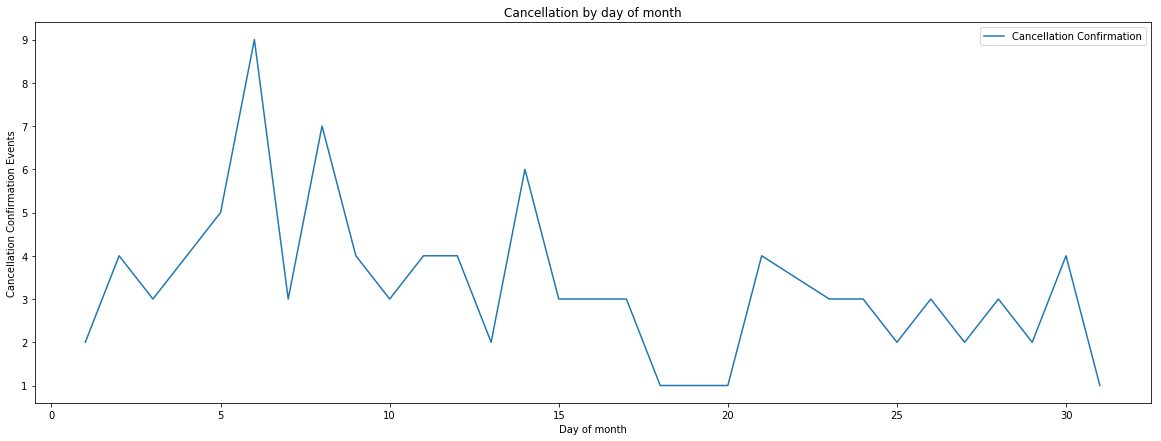

In [63]:
# Check the evolution of Cancellation events over time : day of month

dayOfMonth_count = df.filter(df['page'] == 'Cancellation Confirmation').groupby("day").count().sort('day').toPandas()


# Plot the occurence of Cancelation events over day of month

plt.figure(figsize=(20, 7))
ax = sns.lineplot(x = "day", y = "count", data = dayOfMonth_count)
ax.legend(labels=["Cancellation Confirmation"])
ax.set_title("Cancellation by day of month")
ax.set_xlabel("Day of month")
ax.set_ylabel("Cancellation Confirmation Events");

In [64]:
# Get Weekday Function
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))

# Create Weekday column
df = df.withColumn("weekday", get_weekday(df.ts))

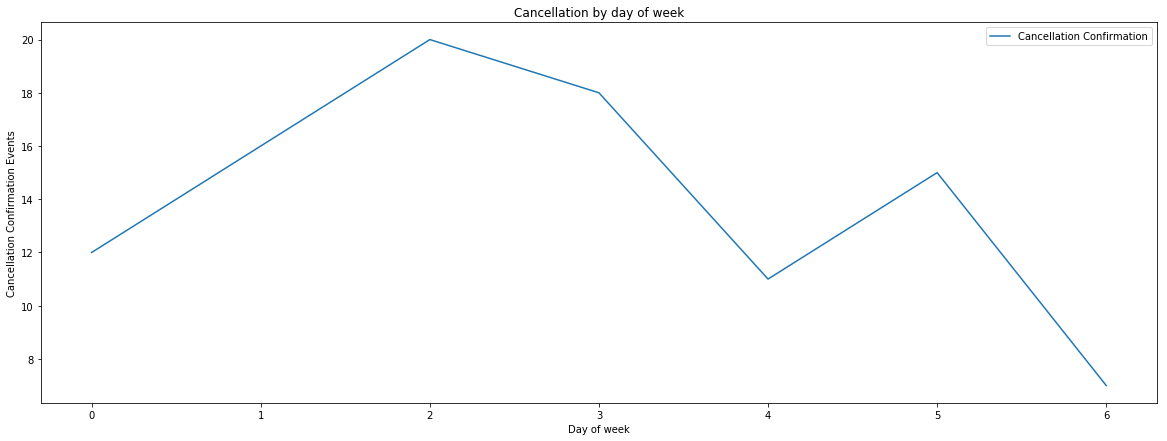

In [65]:
# Check the evolution of Cancellation events over time : day of week

dayOfWeek_count = df.filter(df['page'] == 'Cancellation Confirmation').groupby("weekday").count().sort('weekday').toPandas()


# Plot the occurence of Cancelation events over day of week

plt.figure(figsize=(20, 7))
ax = sns.lineplot(x = "weekday", y = "count", data = dayOfWeek_count)
ax.legend(labels=["Cancellation Confirmation"])
ax.set_title("Cancellation by day of week")
ax.set_xlabel("Day of week")
ax.set_ylabel("Cancellation Confirmation Events");

# 5. Feature Engineering <a id='featureeng'></a>
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

**5.1. Creating new User Features**

1. Categorical Features - most recent value
	- Gender
	- Level (free/paid)
    - Churn
2. Total number of sessions
3. Average time spent per session
4. Total number of Thumbs Up
5. Total number of Thumbs Down
6. Total number of Roll Adverts
7. Total number of Help search
8. Total number of Downgrades
9. Total number of Added Friends
10. Total number of songs played
11. Number of distinct songs played
12. Average number of songs per session

**5.2. Putting all together**

1. Feature Engineering Script
2. ETL Script
    - Extraction Function
    - Transformation Function
    - Loading Function

## 5.1 Creating new User Features <a id='newfeatures'></a>

In [66]:
# 1. Categorical Feature - Gender 

# Convert Gender into a binary variable
#    F --> 0
#    M --> 1
user_gender = df.select("userId", "gender").dropDuplicates().replace(["F", "M"], ["0", "1"], "Gender").select('userId', col('gender').cast('int'))
user_gender.show(5)

+------+------+
|userId|gender|
+------+------+
|   234|     1|
|   188|     0|
|    44|     0|
|   273|     1|
|    46|     0|
+------+------+
only showing top 5 rows



In [67]:
# 1. Categorical Feature - Level 

# Get the timestamp of the last event of each user
user_last_event = df.groupby("userId").max("ts").withColumnRenamed('max(ts)', 'max_ts')

# Get the level of each user for each timestamp
user_last_level = df.select("userId","level","ts").dropDuplicates()

# Join both dataframes on the userId and on the last timestamp for each user
accept_cond = [user_last_level.userId == user_last_event.userId, user_last_level.ts == user_last_event.max_ts]
user_level = user_last_level.join(user_last_event, accept_cond).select(user_last_event.userId,user_last_level.level)

# Convert level into a binary variable
#    free --> 0
#    paid --> 1
user_level = user_level.replace(["free", "paid"], ["0", "1"], "level").select('userId', col('level').cast('int'))
user_level.show(5)

+------+-----+
|userId|level|
+------+-----+
|    12|    1|
|   147|    0|
|   162|    1|
|200028|    1|
|   238|    1|
+------+-----+
only showing top 5 rows



In [68]:
# 1. Categorical Feature - Churn
user_target = df.select('userId', col('Fchurn').alias('target_churn')).dropDuplicates()
user_target.show(5)

+------+------------+
|userId|target_churn|
+------+------------+
|100010|           1|
|200002|           1|
|   296|           1|
|   125|           0|
|   124|           1|
+------+------------+
only showing top 5 rows



In [69]:
# 2. Total number of sessions
user_sessions = df.select("userId", "sessionId").dropDuplicates().groupby("userId").count().withColumnRenamed('count', 'num_sessions')
user_sessions.show(5)

+------+------------+
|userId|num_sessions|
+------+------------+
|   296|           5|
|100010|           2|
|200002|           5|
|   125|           3|
|     7|          15|
+------+------------+
only showing top 5 rows



In [70]:
# 3. Average time spent per session

# Get session duration column in minutes
session_start = df.groupBy('userId', 'sessionId').min('ts').withColumnRenamed('min(ts)', 'session_start')
session_end = df.groupBy('userId', 'sessionId').max('ts').withColumnRenamed('max(ts)', 'session_end')
session_duration = session_start.join(session_end,['userId', 'sessionId'])
session_duration = session_duration.select('userId', 'sessionId', ((session_duration.session_end-session_duration.session_start)/(1000*60)).alias('session_duration_min'))

# Computing average diration per session
user_avg_duration = session_duration.groupBy('userId').agg(avg('session_duration_min').alias('avg_session_duration'))
user_avg_duration = user_avg_duration.na.fill(0)
user_avg_duration.show(5)

+------+--------------------+
|userId|avg_session_duration|
+------+--------------------+
|100010|             210.375|
|200002|  263.06000000000006|
|   296|   97.03666666666666|
|   125|   84.98333333333333|
|     7|  127.17222222222222|
+------+--------------------+
only showing top 5 rows



In [71]:
# 4. Total number of Thumbs Up
user_thumbsup = df.filter(df['page']=='Thumbs Up').select('userId','page').groupBy('userID').count().withColumnRenamed('count', 'num_thumbsup')
user_thumbsup.show(5)

+------+------------+
|userID|num_thumbsup|
+------+------------+
|   296|           8|
|100010|           4|
|200002|          15|
|   125|           3|
|    51|          16|
+------+------------+
only showing top 5 rows



In [72]:
# 5. Total number of Thumbs Down
user_thumbsdown = df.filter(df['page']=='Thumbs Down').select('userId','page').groupBy('userID').count().withColumnRenamed('count', 'num_thumbsdown')
user_thumbsdown.show(5)

+------+--------------+
|userID|num_thumbsdown|
+------+--------------+
|100010|             3|
|200002|             5|
|   125|             1|
|   124|            15|
|    51|             1|
+------+--------------+
only showing top 5 rows



In [73]:
# 6. Total number of Roll Adverts
user_rolladvert = df.filter(df['page']=='Roll Advert').select('userId','page').groupBy('userID').count().withColumnRenamed('count', 'num_rolladvert')
user_rolladvert.show(5)

+------+--------------+
|userID|num_rolladvert|
+------+--------------+
|   296|             9|
|100010|            22|
|200002|            11|
|   125|             6|
|     7|            35|
+------+--------------+
only showing top 5 rows



In [74]:
# 7. Total number of Help searches
user_help = df.filter(df['page']=='Help').select('userId','page').groupBy('userID').count().withColumnRenamed('count', 'num_help')
user_help.show(5)

+------+--------+
|userID|num_help|
+------+--------+
|   296|       2|
|200002|       1|
|   125|       2|
|   124|      10|
|     7|       3|
+------+--------+
only showing top 5 rows



In [75]:
# 8. Total number of Downgrades
user_downgrade = df.filter(df['page']=='Submit Downgrade').select('userId','page').groupBy('userID').count().withColumnRenamed('count', 'num_downgrades')
user_downgrade.show(5)

+------+--------------+
|userID|num_downgrades|
+------+--------------+
|   232|             1|
|   279|             1|
|    29|             1|
|    69|             1|
|100021|             2|
+------+--------------+
only showing top 5 rows



In [76]:
# 9. Total number of Added Friends
user_addfriend = df.filter(df['page']=='Add Friend').select('userId','page').groupBy('userID').count().withColumnRenamed('count', 'num_addfriend')
user_addfriend.show(5)

+------+-------------+
|userID|num_addfriend|
+------+-------------+
|   296|            2|
|100010|            3|
|200002|            2|
|   125|            3|
|   124|           26|
+------+-------------+
only showing top 5 rows



In [77]:
# 10. Total number of Played Songs
user_totalsongs = df.filter(df['song']!='null').select('userId','song').groupBy('userID').count().withColumnRenamed('count', 'num_totalsongs')
user_totalsongs.show(5)

+------+--------------+
|userID|num_totalsongs|
+------+--------------+
|100010|            96|
|200002|           310|
|   296|           112|
|   125|            62|
|   124|          1826|
+------+--------------+
only showing top 5 rows



In [78]:
# 11. Number of distinct songs played
user_distinctsongs = df.select("userId","song").dropDuplicates().groupby("userId").count().withColumnRenamed('count','num_distsongs')
user_distinctsongs.show(5)

+------+-------------+
|userId|num_distsongs|
+------+-------------+
|200002|          307|
|   296|          110|
|100010|           97|
|   125|           63|
|   124|         1612|
+------+-------------+
only showing top 5 rows



In [79]:
# 12. Average number of songs per session
user_avgsongs = df.select("userId","sessionId","song").groupby("userId","sessionId").count()
user_avgsongs = user_avgsongs.groupby("userId").agg(avg(user_avgsongs["count"]).alias("avg_songssession")).sort("avg_songssession", ascending = True)
user_avgsongs.show(5)

+------+----------------+
|userId|avg_songssession|
+------+----------------+
|200044|             3.0|
|   115|             7.8|
|    63|             8.5|
|200033|             9.0|
|200035|            10.0|
+------+----------------+
only showing top 5 rows



## 5.2 Putting All Together <a id='alltogether'></a>

In [4]:
# Define Feature Engineering Function

def feature_engineering(df):
    '''
    This function extracts features from the original dataframe.
    These features will then be used by a ML algorithm to predict churn.
    
    Input:
        df - original spark dataframe
        
    Output:
        features_df - new dataframe with all the new features computed from the original dataset
    '''
    print("-> Starting Feature Engineering...")
    start = datetime.datetime.now()
    
    # Create Churn Flag
    is_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    df = df.withColumn("churn", is_churn_event("page"))
    windowval = Window.partitionBy("userId")
    df = df.withColumn("user_churn", sum("churn").over(windowval))
    user_churn = df.select("userId","user_churn").dropDuplicates()
    print("> Churn Flag")
    
    # Convert Gender into a binary variable (F --> 0, M --> 1)
    user_gender = df.select("userId", "gender").dropDuplicates().replace(["F", "M"], ["0", "1"], "Gender").select('userId', col('gender').cast('int'))
    print("> Gender Flag")
    
    # Convert Level into a binary variable (free --> 0, paid --> 1)
    user_last_event = df.groupby("userId").max("ts").withColumnRenamed('max(ts)', 'max_ts')
    user_last_level = df.select("userId","level","ts").dropDuplicates()
    accept_cond = [user_last_level.userId == user_last_event.userId, user_last_level.ts == user_last_event.max_ts]
    user_level = user_last_level.join(user_last_event, accept_cond).select(user_last_event.userId,user_last_level.level)
    user_level = user_level.replace(["free", "paid"], ["0", "1"], "level").select('userId', col('level').cast('int'))
    print("> Level Flag")
    
    # Total number of sessions
    user_sessions = df.select("userId", "sessionId").dropDuplicates().groupby("userId").count().withColumnRenamed('count', 'num_sessions')
    print("> Total number of sessions")
    
    # Average time spent per session
    session_start = df.groupBy('userId', 'sessionId').min('ts').withColumnRenamed('min(ts)', 'session_start')
    session_end = df.groupBy('userId', 'sessionId').max('ts').withColumnRenamed('max(ts)', 'session_end')
    session_duration = session_start.join(session_end,['userId', 'sessionId'])
    session_duration = session_duration.select('userId', 'sessionId', ((session_duration.session_end-session_duration.session_start)/(1000*60)).alias('session_duration_min'))
    
    user_avg_duration = session_duration.groupBy('userId').agg(avg('session_duration_min').alias('avg_session_duration'))
    user_avg_duration = user_avg_duration.na.fill(0)
    print("> Avg time spent per session")
    
    # Total number o Thumbs Up
    user_thumbsup = df.filter(df['page']=='Thumbs Up').select('userId','page').groupBy('userID').count().withColumnRenamed('count', 'num_thumbsup')
    print("> Total number of Thumbs Up")
    
    # Total number of Thumbs Down
    user_thumbsdown = df.filter(df['page']=='Thumbs Down').select('userId','page').groupBy('userID').count().withColumnRenamed('count', 'num_thumbsdown')
    print("> Total number of Thumbs Down")


    # Total number of Roll Adverts
    user_rolladvert = df.filter(df['page']=='Roll Advert').select('userId','page').groupBy('userID').count().withColumnRenamed('count', 'num_rolladvert')
    print("> Total number of Roll Adverts")


    # Total number of Help searches
    user_help = df.filter(df['page']=='Help').select('userID','page').groupBy('userId').count().withColumnRenamed('count', 'num_help')
    print("> Total number of Help searches")


    # Total number of Downgrades
    user_downgrade = df.filter(df['page']=='Submit Downgrade').select('userId','page').groupBy('userID').count().withColumnRenamed('count', 'num_downgrades')
    print("> Total number of Downgrades")

    # Total number of Added Friends
    user_addfriend = df.filter(df['page']=='Add Friend').select('userId','page').groupBy('userID').count().withColumnRenamed('count', 'num_addfriend')
    print("> Total number of Added Friends")

    # Total number of Played Songs
    user_allsongs = df.filter(df['song']!='null').select('userId','song').groupBy('userID').count().withColumnRenamed('count', 'num_songs')
    print("> Total number of Played Songs")

    # Number of distinct songs played
    user_uniquesongs = df.select("userId","song").dropDuplicates().groupby("userId").count().withColumnRenamed('count','num_uniquesongs')
    print("> Total number of distinct Songs played")

    # Average number of songs per session
    user_avgsongs = df.select("userId","sessionId","song").groupby("userId","sessionId").count()
    user_avgsongs = user_avgsongs.groupby("userId").agg(avg(user_avgsongs["count"]).alias("avg_songssession"))
    print("> Average number of songs per session")
    
    # Joining all features
    features_df = user_gender.join(user_level,"userId","outer")\
    .join(user_sessions,"userId","outer")\
    .join(user_avg_duration,"userId","outer")\
    .join(user_thumbsup,"userId","outer")\
    .join(user_thumbsdown,"userId","outer")\
    .join(user_rolladvert,"userId","outer")\
    .join(user_help,"userId","outer")\
    .join(user_downgrade,"userId","outer")\
    .join(user_addfriend,"userId","outer")\
    .join(user_allsongs,"userId","outer")\
    .join(user_uniquesongs,"userId","outer")\
    .join(user_avgsongs,"userId","outer")\
    .join(user_churn,"userId","outer")\
    .fillna(0)
    
    print ("-> Final dataframe shape:",features_df.count(), "rows and",len(features_df.dtypes),"columns")
    print ("-> Duration:",datetime.datetime.now()-start,"s")
    print ("-> Feature Engineering ended with Success")
    
    return features_df

In [81]:
features_df = feature_engineering(df)

-> Starting Feature Engineering...
> Churn Flag
> Gender Flag
> Level Flag
> Total number of sessions
> Avg time spent per session
> Total number of Thumbs Up
> Total number of Thumbs Down
> Total number of Roll Adverts
> Total number of Help searches
> Total number of Downgrades
> Total number of Added Friends
> Total number of Played Songs
> Total number of distinct Songs played
> Average number of songs per session
-> Final dataframe shape: 448 rows and 15 columns
-> Duration: 0:01:38.075591 s
-> Feature Engineering ended with Success


In [82]:
# Check new dataframe
features_df.toPandas().head(10)

,userId,gender,level,num_sessions,avg_session_duration,num_thumbsup,num_thumbsdown,num_rolladvert,num_help,num_downgrades,num_addfriend,num_songs,num_uniquesongs,avg_songssession,user_churn
0,100010,0,0,2,210.375000,4,3,22,0,0,3,96,97,68.500000,1
1,200002,1,1,5,263.060000,15,5,11,1,0,2,310,307,79.000000,1
2,296,0,1,5,97.036667,8,0,9,2,0,2,112,110,30.400000,1
3,125,1,0,3,84.983333,3,1,6,2,0,3,62,63,28.000000,0
4,124,0,1,17,445.667647,102,15,1,10,0,26,1826,1612,126.823529,1
5,51,1,1,5,219.683333,16,1,1,0,0,3,266,254,65.600000,1
6,7,1,0,15,127.172222,12,4,35,3,0,16,462,448,40.000000,0
7,200037,1,0,7,68.009524,5,3,9,0,0,2,122,121,22.142857,1
8,169,1,0,8,54.600000,6,0,13,0,0,6,112,113,18.625000,0
9,205,0,1,5,874.220000,50,10,0,11,0,21,1048,967,248.800000,0


In [83]:
# Check new features data types
features_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- num_sessions: long (nullable = true)
 |-- avg_session_duration: double (nullable = false)
 |-- num_thumbsup: long (nullable = true)
 |-- num_thumbsdown: long (nullable = true)
 |-- num_rolladvert: long (nullable = true)
 |-- num_help: long (nullable = true)
 |-- num_downgrades: long (nullable = true)
 |-- num_addfriend: long (nullable = true)
 |-- num_songs: long (nullable = true)
 |-- num_uniquesongs: long (nullable = true)
 |-- avg_songssession: double (nullable = false)
 |-- user_churn: long (nullable = true)



**Now we are going to create a script that performs all the tasks we have performed so far, and thus, synthesizing the entire ETL process.**

In [5]:
# Define Data Extraction Function

def extract_data(path):
    '''
    This function extracts the raw dataset in json format, which will be used for modelling churn.
    
    Input:
        path - path where the dataset is stored
        
    Output:
        df - raw spark dataframe 
    '''
    df = spark.read.json(path)
    
    return df

In [6]:
# Define Data Transformation Function

def transform_data(df):
    '''
    This function transforms the raw spark dataframe into a clean dataframe, ready to be used by a ML algorithm to predict churn.
    The transformations include:
        - removing unidentified users
        - performing feature engineering
    
    Input:
        df - raw spark dataframe  
        
    Output:
        model_df - dataframe ready for modelling
    '''
    
    # Drop NaN values
    df = df.dropna(how = "any", subset = ["userId", "sessionId"])
    
    # Drop rows with unidentified users
    df = df.filter(df.userId != "")
    
    # Feature Engineering
    features_df = feature_engineering(df)
    
    # Drop UserId
    model_df = features_df.drop("userId")
    
    return model_df

In [7]:
# Define Data Loading Function

def load_data(model_df, outpath):
    """
    This function saves the transformed modelling data into a .csv file.
    
    Inputs:
        model_df: the modelling dataframe
        outpath: the output path with the file name
    """
    model_df.write.csv(outpath, header=True)

In [8]:
# Define Perform ETL Function

def perform_etl(path, outpath):
    '''
    This function performs full ETL tasks.
    It extracts the raw dataset from its location, applies all relevant transformations and returns a final dataframe ready to be used for modelling and predict churn.
    The function also saves the final dataframe in a .csv file on the specified outpath-
    
    Inputs:
        path - path where the raw dataset is stored
        outpath - the output path with the file name
    
    Outputs:
        model_df - spark dataframe ready for modelling
    '''
    
    print("> Starting data extraction ...")
    #Extract
    df = extract_data(path)
    
    print("> Starting data transformation ...")
    #Transform
    model_df = transform_data(df)
    
    print("> Starting data loading")
    #Load
    #load_data(model_df, outpath)
    
    print("> Final dataframe saved with success")
    print("> End of ETL process")
    
    return model_df
    

In [9]:
model_df = perform_etl(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-hcuyrew6c31cer'),'sparkify_final_data.csv' )

> Starting data extraction ...
> Starting data transformation ...
-> Starting Feature Engineering...
> Churn Flag
> Gender Flag
> Level Flag
> Total number of sessions
> Avg time spent per session
> Total number of Thumbs Up
> Total number of Thumbs Down
> Total number of Roll Adverts
> Total number of Help searches
> Total number of Downgrades
> Total number of Added Friends
> Total number of Played Songs
> Total number of distinct Songs played
> Average number of songs per session
-> Final dataframe shape: 448 rows and 15 columns
-> Duration: 0:02:57.601696 s
-> Feature Engineering ended with Success
> Starting data loading
> Final dataframe saved with success
> End of ETL process


# 6. Modeling <a id='modeling'></a>
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [90]:
# Dataset disbribution by target variable
model_df.groupby("user_churn").count().show()

+----------+-----+
|user_churn|count|
+----------+-----+
|         0|  349|
|         1|   99|
+----------+-----+



## 6.1 Vectorize, Scaling and Split data <a id='vectandpslit'></a>

In [10]:
# Convert all features into a vector
features = ["gender","level","num_sessions","avg_session_duration","num_thumbsup","num_thumbsdown","num_rolladvert","num_help","num_downgrades","num_addfriend","num_songs","num_uniquesongs","avg_songssession"]

assembler = VectorAssembler(inputCols = features, outputCol = "NumFeatures")

df = assembler.transform(model_df)

In [11]:
# Scaling the Vectors with the StandardScaler method
scaler = StandardScaler(withMean=True, withStd=True, inputCol='NumFeatures', outputCol='ScaledNumFeatures')
scalerModel = scaler.fit(df)
scaled_df = scalerModel.transform(df)

In [12]:
# Join scaled features with the target label (user_churn)
df = scaled_df.select(df.user_churn.alias('label'), scaled_df.ScaledNumFeatures.alias('features'))

In [94]:
df.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|[-1.1224116448223...|
|    1|[0.88895002269933...|
|    1|[-1.1224116448223...|
|    0|[0.88895002269933...|
|    1|[-1.1224116448223...|
|    1|[0.88895002269933...|
|    0|[0.88895002269933...|
|    1|[0.88895002269933...|
|    0|[0.88895002269933...|
|    0|[-1.1224116448223...|
+-----+--------------------+
only showing top 10 rows



In [13]:
# Train, Test split
train, test = df.randomSplit([0.8, 0.2], seed=42)

## 6.2 Train, Predict and Tune different models <a id='trainpredict'></a>

In order to achieve the best prediction, we will train and predict on differen algorithms and then compare their results and performance coefficients. 

    In terms of algorithms we will compare:
        - Random Forest
        - Gradient-Boosted Tree
        - Decision Tree
        - Logistic Regression
        - LinearSVC
        
    In terms of metrics to assess performance we will compare:
        - Accuracy
        - F-1 score
        - Time to train

In [14]:
def train_predict(train, test):
    '''
    This function will train several models using the train and test datasets previously built.
    Each model will be assessed on its accuracy, F-1 Scorem and on time to train.
    All results will then be plotted and compared.
    
    Inputs:
        train - train dataset
        test - test dataset
        
    Outputs:
        classifier - all the classifiers that were tested
        accuracy - accuracy score for all the classifiers
        f1score - f1 score for all the classifiers
        timetrain - the time it took for training for each one of the classifiers
        bestclass - best classifier based on f1 score
    '''
    
    # Auxiliar lists
    classifier = []
    accuracy = []
    f1score = []
    timetrain = []
    f1score_aux = 0
    f1score_aux2 = 0
    
    # Training and predicting
    print(" Start Training ...")
    print("> Random Forest Classifier")
    
    ## Random Forest Classifier
    rf_start = datetime.datetime.now()
    rf_model = RandomForestClassifier(labelCol="label", featuresCol="features")
    paramGrid = ParamGridBuilder().addGrid(rf_model.maxDepth,[5, 10]).addGrid(rf_model.impurity,['entropy', 'gini']).addGrid(rf_model.numTrees ,[10, 20]).build()
    f1_eval = MulticlassClassificationEvaluator(metricName='f1')
    crossval = CrossValidator(estimator=rf_model,estimatorParamMaps=paramGrid,evaluator=f1_eval,numFolds=3)
    
    rf_model = crossval.fit(train)
    results = rf_model.transform(test)
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    
    # Saving results
    classifier.append("Random Forest Classifier")
    accuracy.append(evaluator.evaluate(results, {evaluator.metricName: "accuracy"}))
    f1score_aux = (evaluator.evaluate(results, {evaluator.metricName: "f1"}))
    f1score.append(f1score_aux)
    rf_end = datetime.datetime.now()
    timetrain.append((rf_end-rf_start).total_seconds())
    bestclass = rf_model
    print("  >Random Forest Classifier fitted with success")
    

    print("> Gradient-Boosted Trees")
    ## Gradient-Boosted Trees
    gbt_start = datetime.datetime.now()
    gbt_model = GBTClassifier(labelCol="label", featuresCol="features",maxIter=10,seed=42)
    paramGrid = ParamGridBuilder().addGrid(gbt_model.maxDepth,[2, 3, 5]).addGrid(gbt_model.maxIter, [5, 10]).build()
    f1_eval = MulticlassClassificationEvaluator(metricName='f1')
    crossval = CrossValidator(estimator = gbt_model, estimatorParamMaps = paramGrid, evaluator=f1_eval, numFolds=3)
    
    gbt_model = crossval.fit(train)
    results = gbt_model.transform(test)
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    
    # Saving results
    classifier.append("Gradient Boosted Trees")
    accuracy.append(evaluator.evaluate(results, {evaluator.metricName: "accuracy"}))
    f1score_aux2 = (evaluator.evaluate(results, {evaluator.metricName: "f1"}))
    f1score.append(f1score_aux2)
    gbt_end = datetime.datetime.now()
    timetrain.append((gbt_end-gbt_start).total_seconds())
    if f1score_aux2>f1score_aux:
        bestclass=gbt_model
        f1score_aux=f1score_aux2
    print("  >Gradient Boosted Tree fitted with success")
     
    
    print("> Decision Tree Classifier")
    ## Decision Tree Classifier
    dt_start = datetime.datetime.now()
    dt_model = DecisionTreeClassifier(labelCol="label", featuresCol="features",seed=42)
    paramGrid = ParamGridBuilder().addGrid(dt_model.impurity,['entropy', 'gini']).addGrid(dt_model.maxDepth,[2, 3, 4, 5, 8, 10, 15]).build()
    f1_eval = MulticlassClassificationEvaluator(metricName='f1')
    crossval = CrossValidator(estimator=dt_model,estimatorParamMaps=paramGrid,evaluator=f1_eval,numFolds=3)
    
    dt_model = crossval.fit(train)
    results = dt_model.transform(test)
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    
    # Saving results
    classifier.append("Decision Tree Classifier")
    accuracy.append(evaluator.evaluate(results, {evaluator.metricName: "accuracy"}))
    f1score_aux2 = (evaluator.evaluate(results, {evaluator.metricName: "f1"}))
    f1score.append(f1score_aux2)
    dt_end = datetime.datetime.now()
    timetrain.append((dt_end-dt_start).total_seconds())
    if f1score_aux2>f1score_aux:
        bestclass=dt_model
        f1score_aux=f1score_aux2
    print("  >Decision Tree Classifier fitted with success")
    
    
    print("> Logistic Regression Classifier")
    ## Logistic Regression
    lr_start = datetime.datetime.now()
    lr_model = LogisticRegression(labelCol="label", featuresCol="features",maxIter=10)
    paramGrid = ParamGridBuilder().addGrid(lr_model.elasticNetParam,[0.0, 0.1, 0.4, 1.0]).addGrid(lr_model.regParam,[0.0, 0.05, 0.1]).build()
    f1_eval = MulticlassClassificationEvaluator(metricName='f1')
    crossval = CrossValidator(estimator=lr_model,estimatorParamMaps=paramGrid,evaluator=f1_eval,numFolds=3)
    
    lr_model = crossval.fit(train)
    results = lr_model.transform(test)
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    
    # Saving results
    classifier.append("Logistic Regression")
    accuracy.append(evaluator.evaluate(results, {evaluator.metricName: "accuracy"}))
    f1score_aux2 = (evaluator.evaluate(results, {evaluator.metricName: "f1"}))
    f1score.append(f1score_aux2)
    lr_end = datetime.datetime.now()
    timetrain.append((lr_end-lr_start).total_seconds())
    if f1score_aux2>f1score_aux:
        bestclass=lr_model
        f1score_aux=f1score_aux2
    print("  >Logistic Regression Classifier fitted with success")
    
    
    print("> Linear SVC Classifier")
    ## Linear SVC
    svc_start = datetime.datetime.now()
    svc_model = LinearSVC(labelCol="label", featuresCol="features")
    paramGrid = ParamGridBuilder().addGrid(svc_model.maxIter ,[5, 10]).addGrid(svc_model.regParam ,[0.01, 0.05, 0.1]).build()
    f1_eval = MulticlassClassificationEvaluator(metricName='f1')
    crossval = CrossValidator(estimator=svc_model,estimatorParamMaps=paramGrid,evaluator=f1_eval,numFolds=3)
    
    svc_model = crossval.fit(train)
    results = svc_model.transform(test)
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    
    # Saving results
    classifier.append("Linear SVC")
    accuracy.append(evaluator.evaluate(results, {evaluator.metricName: "accuracy"}))
    f1score_aux2 = (evaluator.evaluate(results, {evaluator.metricName: "f1"}))
    f1score.append(f1score_aux2)
    svc_end = datetime.datetime.now()
    timetrain.append((svc_end-svc_start).total_seconds())
    if f1score_aux2>f1score_aux:
        bestclass=svc_model
        f1score_aux=f1score_aux2
    print("  >Linear SVC Classifier fitted with success")
    
    print("All models trained with success")
   
    return classifier, accuracy, f1score, timetrain, bestclass;

In [15]:
# Apply train_predict Function
classifier, accuracy, f1score, timetrain, bestclass = train_predict(train, test)

 Start Training ...
> Random Forest Classifier
  >Random Forest Classifier fitted with success
> Gradient-Boosted Trees
  >Gradient Boosted Tree fitted with success
> Decision Tree Classifier
  >Decision Tree Classifier fitted with success
> Logistic Regression Classifier
  >Logistic Regression Classifier fitted with success
> Linear SVC Classifier
  >Linear SVC Classifier fitted with success
All models trained with success


## 6.3 Model Selection and Results<a id='selection'></a>

In [105]:
def plot_results(classifier, accuracy, f1score, timetrain): 
    '''
    This function will plot the results for each classifier.
    
    Inputs:
            classifier - all the classifiers that were tested
        accuracy - accuracy score for all the classifiers
        f1score - f1 score for all the classifiers
        timetrain - the time it took for training each classifier
        
    Output:
        NA
    '''
    
    # Creating dataframe with metrics
    metrics = pd.DataFrame(columns=['classifier', 'accuracy', 'f1score','time'])
    metrics['classifier']=classifier
    metrics['accuracy']=accuracy
    metrics['f1score']=f1score
    metrics['time']=timetrain
    
    print(metrics)
    
    # Plot Accuracy
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='classifier', y='accuracy', orient="v", data=metrics)
    ax.set_title("Accuracy by classifier")
    ax.set_xlabel("Classifier")
    ax.set_ylabel("Accuracy")
    ax.set_ylim(0, 1)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.4f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
    # Plot F1score
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='classifier', y='f1score', orient="v", data=metrics)
    ax.set_title("F1 Score by classifier")
    ax.set_xlabel("Classifier")
    ax.set_ylabel("F1 Score")
    ax.set_ylim(0, 1)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.4f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
    
    # Plot Time to train
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='classifier', y='time', orient="v", data=metrics)
    ax.set_title("Time to train by classifier")
    ax.set_xlabel("Classifier")
    ax.set_ylabel("Time to train [s]")
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.4f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
    
    return ;

                 classifier  accuracy   f1score         time
0  Random Forest Classifier  0.720930  0.676908  2173.506121
1    Gradient Boosted Trees  0.732558  0.712646  2374.034594
2  Decision Tree Classifier  0.744186  0.644961  1857.708818
3       Logistic Regression  0.755814  0.650701  1630.012932
4                Linear SVC  0.755814  0.650701  1660.288756


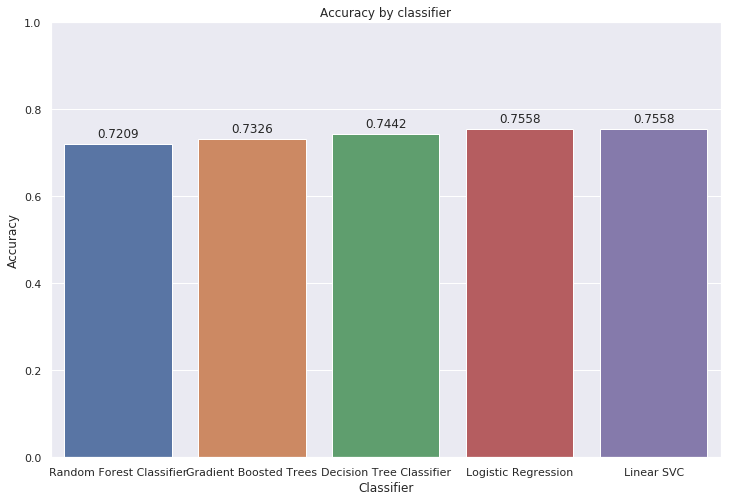

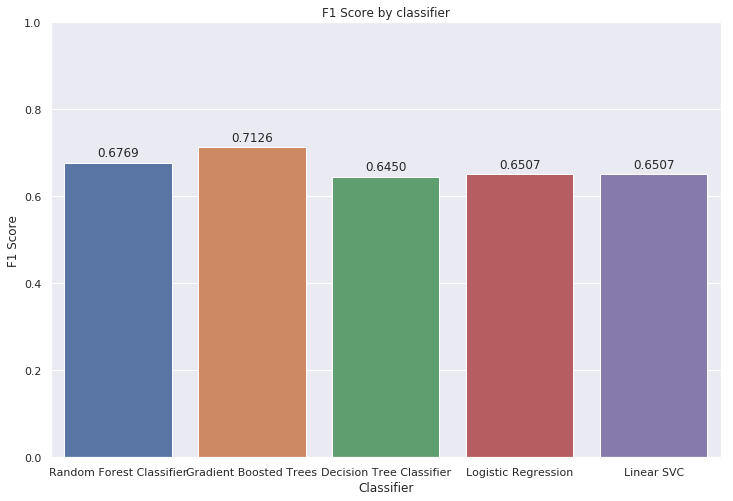

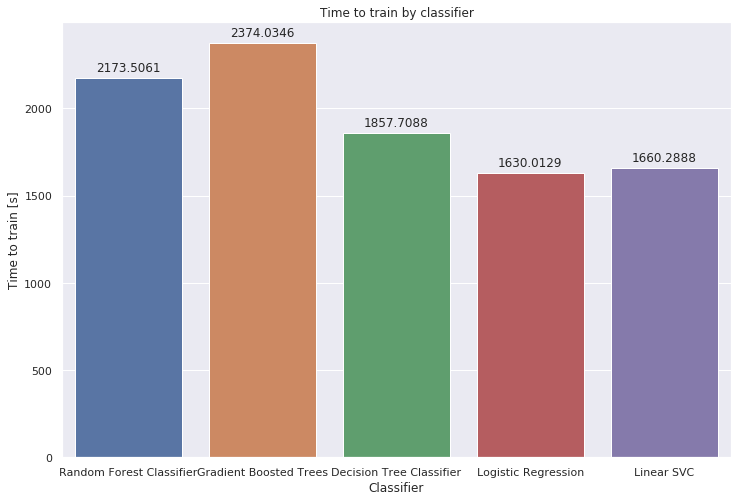

In [106]:
# Pltoting scores
plot_results(classifier, accuracy, f1score, np.array(timetrain))

> Because the churned users are a fairly imbalanced subset, F1 score is the metric we want to optimize as it gives a better measure of the incorrectly classified cases than the Accuracy Metric, penelazing the extreme values. 

> From the results above, the best model with better performance was **Gradient Boosted Trees** (best F1-Score), which uses an ensemble of decision trees to predict the target label. Although all models have a similar accuracy, the Gradient Boosted Trees stands out for having the best F1-Score. After fine tuning the parameters, the best version of the Gradient Boosted Trees obtained an **accuracy equal to 73,25% and an F1 Score equal to 0.7126.**
  
>If our decision metric was seeking the balance between the best results and the processing efficiency (better training time) this would probably not be our option. The **Logistic Regression model**, for example, has a more interesting processing time. 

> However, it should be noted that no model has shown efficiency in "time to train", taking a long time even using technology such as Spark to distribute computing across several nodes. When working with larger datasets, time efficiency it would be an important factor to consider and improve.


In [16]:
# Best Model & Parameters
model=bestclass.bestModel
print("-> Model:", model)

-> Model: RandomForestClassificationModel (uid=RandomForestClassifier_3156682f0a3a) with 20 trees


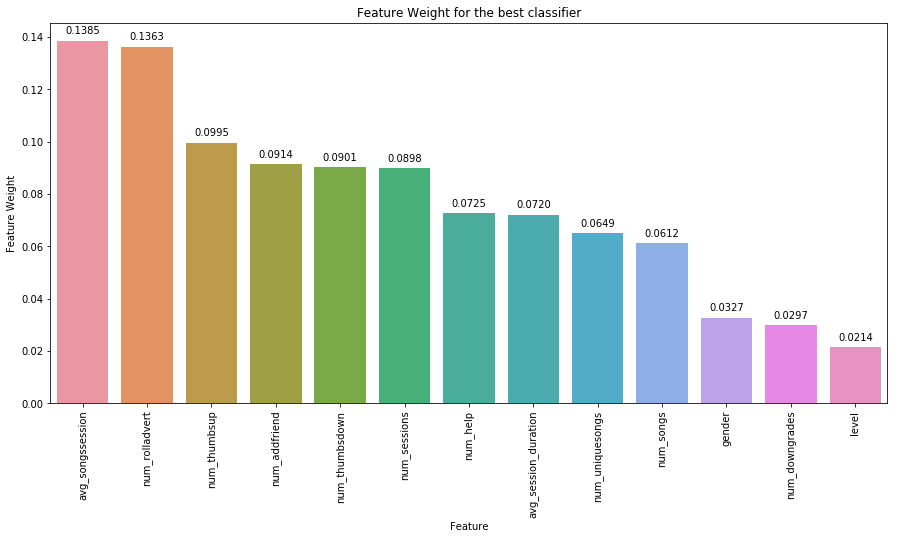

In [17]:
# Feature Weight
feat_weight = model.featureImportances
features = ["gender","level","num_sessions","avg_session_duration","num_thumbsup","num_thumbsdown","num_rolladvert","num_help","num_downgrades","num_addfriend","num_songs","num_uniquesongs","avg_songssession"]
data_features = pd.DataFrame()
data_features['features']=features
data_features['feat_weight']=feat_weight
data_features = data_features.sort_values(by='feat_weight', ascending = False)

# Plot
plt.figure(figsize=(15, 7))
ax = sns.barplot(x='features', y='feat_weight', orient="v", data=data_features)
ax.set_title("Feature Weight for the best classifier")
ax.set_xlabel("Feature")
ax.set_ylabel("Feature Weight")
ax.set_xticklabels(labels=data_features['features'],rotation=90)
for p in ax.patches:
        ax.annotate(format(p.get_height(), '.4f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

> When looking at the feature importance, the **average number of songs per session** stands out, what means that this feature has a higher influence in user's churn. This metric mirrors the customer's engagement with the application, and therefore customers who on average listen to less songs are more likely to abandon the service.

> The second most relevant feature is the **number of thumb downs**. These types of events are also good indications of customer dissatisfaction. It may be the case that the customer does not like the songs that are being recommended.

> The third most important feature also seems quite relevant, as it represents the **number of times the customer has sought help** in the application.

> Features such as level, number of friends added, number of downgrades or gender are not good indicators of customer's churn.


# 7. Conclusions <a id='conclusions'></a>

The project was successfuly developed and implemented in the IBM Watson Study workspace. To handle the size of the dataset, all steps, from data loading to processing, feature engineering and machine learning, were processed with Spark. 

In order to predict the churn of users of the Sparkify service, it was defined as a trigger the event of cancelling the account, represented in the dataset by the page name "Confirm Cancellation". 

After exploring the data and evaluating the behavior of each variable in the event of churn or non-churn, 13 numerical features were created to simplify the characterization of users.These features were then compared across the two groups of users (churners and non-churners) to identify which ones could potentially be interesting in predicting churn.

After splitting the dataset into training and testing, 5 classification models were trained on the training set (with crossvalidation) and the hyperparameters were tuned using Grid Search.

Finally, the model that produced the best results to predict churn was identified, the Gradient Boosted Trees, with an F1- Score of 71.26%. Although we divided the processing by several nodes, the average time to train and fine-tune each model was 1939 seconds, which is approximately 32 minutes. The training time of the winning model was even above average, almost 40 minutes. This is a relatively high time and could be improved. However, after finding the "optimal" parameters, processing can also be much faster.

#### Challenges

During this project there were two main challenges.

The first one was related with the implementation and development of pyspark code. Although it is intuitive and very similar to SQL, it has its own peculiarities and requirements, and therefore was necessary a further look at the official documentation and at the available features.

The second challenge was related to the importance of the feature engineering process. In this process, it is supposed to derive new features that simplify and enhance the features and insights hidden in the data. A good feature engineering has a direct impact on the quality of the results. To produce meaningful features it is required an exhaustive exploratory analysis and a deep knowledge of the dataset.

#### Improvement & Next Steps

Although we achieved a good result (73% acc and 0,71 F1 score), there are some aspects that could be improved, such as:
* Work with the complete dataset in order to have more samples and, ideally, have a balanced data set (similar number of churn and not churn users);
* Improve feature engineering by adding more relevant features;
* Use a dimensionality reduction methods like PCA to reduce variability and select the most revelevant features before training;
* Improve computation time and explore more parameters in the hyperparameters tuning.